# Fraudes con tarjetas de credito
### Caracterización:
Los pagos digitales están evolucionando, pero también los ciberdelincuentes. Según el índice de violación de datos, se roban más de 5 millones de registros diariamente, una estadística preocupante que muestra que el fraude sigue siendo muy común tanto para el tipo de pago con tarjeta presente como con tarjeta no presente. En el mundo digital actual, donde se realizan billones de transacciones con tarjeta por día, la detección del fraude con tarjetas de crédito es un desafío.

En el presente trabajo se intenta analizar la siguiente base de datos que provee información sobre transacciones con tarjetas de credito, para luego impementar un modelo de Arbol de Decision que sea capaz de predecir si una transaccion es o no fraudulenta.

Para ello, primero se realizara un analisis exploratorio de los datos para conocer ciertas caracteristicas de la base de datos, asi como el comportamiento de las variables que la componen.

Luego se implementara un modelo de arbol de decision, probando diferentes hiperparametros para obtener resultados un tanto más óptimos y se analizara la matriz de confusion y algunas metricas para analizar los resultados.

Todo lo aterior sera posible importando las siguientes librerias

In [1]:
import numpy as np                          # analisis numérico 
import pandas as pd                         # manejo de datos
import matplotlib.pyplot as plt             # Gráficos
import seaborn as sns                       # Gráficos

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, make_scorer
import scikitplot as skplt

In [2]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from sklearn.tree import export_graphviz

import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Analisis Exploratorio
Como primera medida, se carga la base de datos y es almacenada en la variable "df". Luego se muestran los primeros 5 elementos para corroborar que se cargo correctamente y para ir conociendo un poco como esta conformada.

In [3]:
df = pd.read_csv("Fraudes con tarjeta de credito.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


#### Las variables incluidas en el dataset son:
distancefromhome - la distancia a la que la transacción ocurrió desde la dirección de facturación

distancefromlast_transaction - la distancia de la última transacción

ratiotomedianpurchaseprice - ratio del monto de transacción sobre la mediana

repeat_retailer - si la transacción se dió sobre un retailer repetido

used_chip - si la transacción es por chip

usedpinnumber - si la transacción es por PIN

online_order - si la transacción es online

fraud - si la transacción fue o no fraudulenta

En el codigo que sigue, podemos saber que la base de datos esta conformada de 8 columnas, las cuales se accaban de mencionar, y 1000000 de filas.

In [4]:
df.shape

(1000000, 8)

A continuación, se comprueba que es un dataset que no requiere limpieza ya que no contamos con datos nulos ni filas repetidas.

In [5]:
df.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

Para ir terminando con las caracteristicas principales de la base de datos se implementa la funcion `info()` para una descripción de generica del dataset, asi como los tipos de datos de cada variable

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [7]:
df.nunique()

distance_from_home                1000000
distance_from_last_transaction    1000000
ratio_to_median_purchase_price    1000000
repeat_retailer                         2
used_chip                               2
used_pin_number                         2
online_order                            2
fraud                                   2
dtype: int64

Antes de entrar de lleno en el estudio de las variables del dataset se realiza una breve descripción estadistica de las mismas para tener una noción más clara del comportamiento de sus valores.

In [8]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Lo primero que nos interesa analizar es la variable respuesta "fraud". Como era de esperar, en los siguientes codigos se concluye claramente que es una variable altamente desbalanceada, donde aproximadamente el 91% de los datos corresponde a datos no fraudulentos. Esto sera tratado con cuidado en la implementación del Arbol de Decision

In [9]:
df['fraud'].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

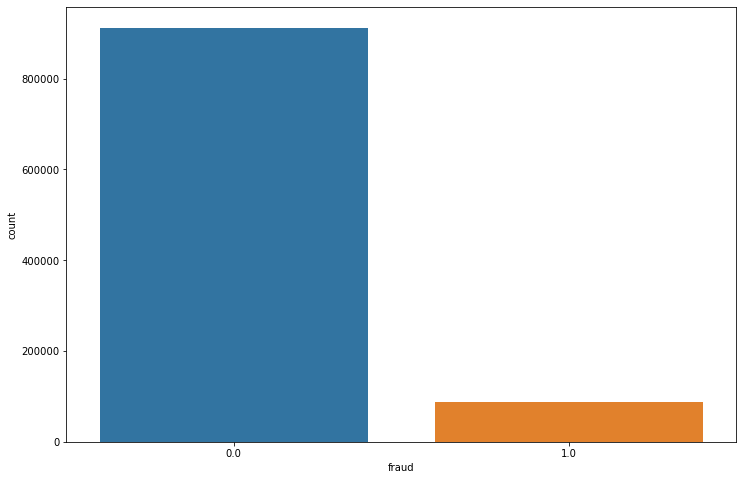

In [10]:
plt.figure(figsize = (12, 8))
sns.countplot(x = 'fraud', data = df)
plt.show()

ESTUDIO DE LA VARIABLE "online_order" EN RELACION A LA VARIABLE RESPUESTA

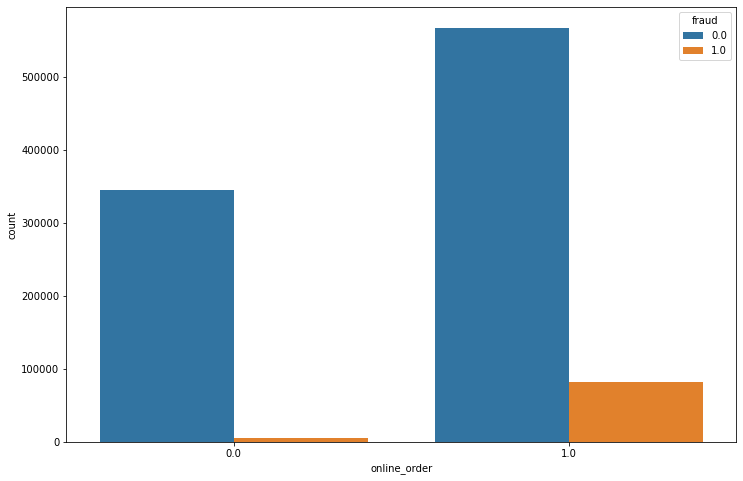

In [11]:

plt.figure(figsize=(12, 8))
sns.countplot(x = 'online_order', data = df, hue = 'fraud')
plt.show()

In [12]:
pd.crosstab(df['online_order'], df['fraud'])

fraud,0.0,1.0
online_order,,
0.0,344756,4692
1.0,567841,82711


De los datos anteriores se puede ver que la proporcion de transacciones fraudulentas es mucho mayor cuando las transacciones son oline

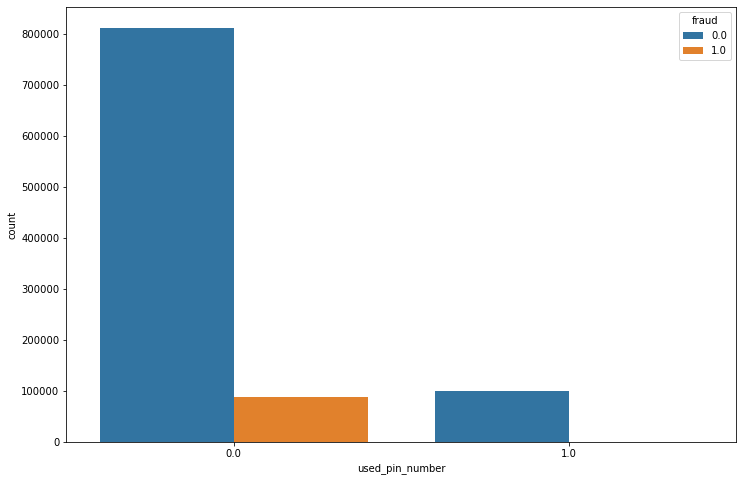

In [13]:
# ESTUDIO DE LA VARIABLE "used_pin_number" EN RELACION A LA VARIABLE RESPUESTA
plt.figure(figsize=(12, 8))
sns.countplot(x = 'used_pin_number', data = df, hue = 'fraud')
plt.show()

In [14]:
pd.crosstab(df['used_pin_number'], df['fraud'])

fraud,0.0,1.0
used_pin_number,,
0.0,812262,87130
1.0,100335,273


Aqui se descubre que son muy recurrente las transacciones fraudulentas cuando la transaccion no se realiza por numero de PIN, por lo que puede decirse (la rigurosidad del analisis de inferencia estadistica queda para otro momento) que las transacciones mediante numero de PIN pueden ser un tanto mas seguras.

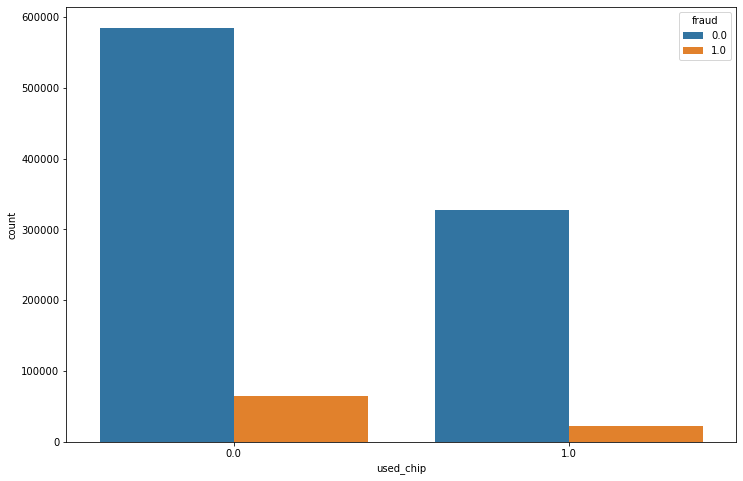

In [15]:
# ESTUDIO DE LA VARIABLE "used_chip" EN RELACION A LA VARIABLE RESPUESTA
plt.figure(figsize=(12, 8))
sns.countplot(x = 'used_chip', data = df, hue = 'fraud')
plt.show()

In [16]:
pd.crosstab(df['used_chip'], df['fraud'])

fraud,0.0,1.0
used_chip,,
0.0,584608,64993
1.0,327989,22410


Ahora ses muestra un grafico de correlaciones para indagar un poco sobre la relacion numerica que existe entre las variables con la variable respuesta 

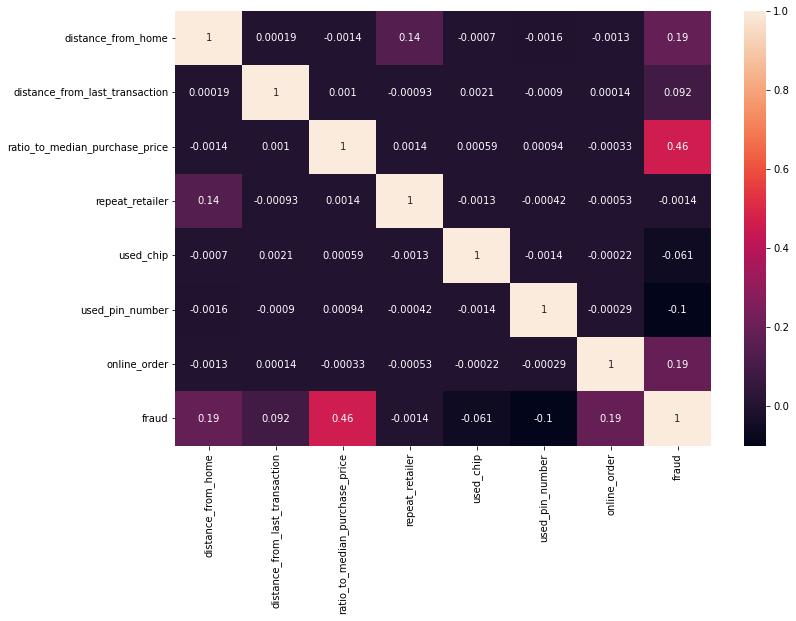

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

En el grafico anterior se puede obserar que la variable que contiene el ratio sobre la mediana de la transaccion esta correlacionado positivamente con la variable respuesta. Ademas, la variabla "distancia from home" tambien marca cierta correlaccion aunque un tanto menor. Lo que queda es ver si el algoritmo tambien detecta a estas variables como predictores importantes.

Ahora se intentara hacer una descripcion de los datos correspondientes a las variables continuas

In [18]:
df['distance_from_home'].describe()

count    1000000.000000
mean          26.628792
std           65.390784
min            0.004874
25%            3.878008
50%            9.967760
75%           25.743985
max        10632.723672
Name: distance_from_home, dtype: float64

In [19]:
## Trabajando con el problema de la distancia
df['distancia'] = 0

df.loc[df['distance_from_home'] <= 3.878008, 'distancia'] = 0
df.loc[(df['distance_from_home']>3.878008) & (df['distancia']<= 9.967760), 'distancia'] = 1
df.loc[(df['distance_from_home']>9.967760) & (df['distancia']<= 25.743985), 'distancia'] = 2
df.loc[df['distance_from_home']>25.743985, 'distancia'] = 3

In [20]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,distancia
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0,3
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0,2
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0,1
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0,0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0,3


In [21]:
pd.crosstab(df['distancia'], df['fraud'])

fraud,0.0,1.0
distancia,,
0,230775,19225
1,233512,16488
2,233691,16309
3,214619,35381


In [22]:
df[df['distancia'] == 3]['distance_from_home'].describe()

count    250000.000000
mean         81.610556
std         113.764578
min          25.744027
25%          34.653174
50%          50.101539
75%          85.603962
max       10632.723672
Name: distance_from_home, dtype: float64

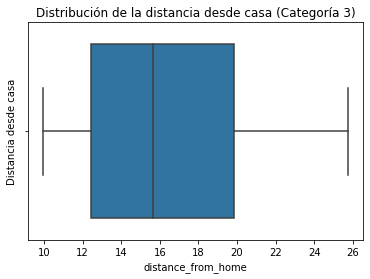

In [23]:
sns.boxplot(df[df['distancia'] == 2]['distance_from_home'])
plt.ylabel('Distancia desde casa')
plt.title('Distribución de la distancia desde casa (Categoría 3)')
plt.show()

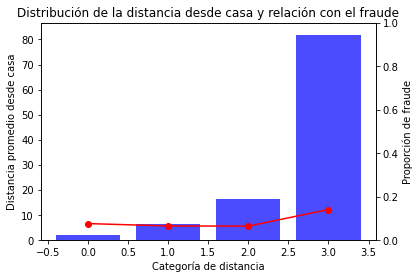

In [24]:
# Agrupa los datos por la variable "distancia" y calcula la media de "distance_from_home" y la proporción de fraude
grouped_data = df.groupby('distancia').agg({'distance_from_home': 'mean', 'fraud': 'mean'})

# Crea un gráfico de barras para mostrar la distribución de "distance_from_home" en cada categoría y la proporción de fraude
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Eje secundario para mostrar la proporción de fraude

ax1.bar(grouped_data.index, grouped_data['distance_from_home'], color='blue', alpha=0.7)
ax1.set_ylabel('Distancia promedio desde casa')
ax1.set_xlabel('Categoría de distancia')
ax1.set_ylim([0, max(grouped_data['distance_from_home']) + 5])

ax2.plot(grouped_data.index, grouped_data['fraud'], color='red', marker='o')
ax2.set_ylabel('Proporción de fraude')
ax2.set_ylim([0, 1])

plt.title('Distribución de la distancia desde casa y relación con el fraude')
plt.show()

Con la implementacion de este grafico se puede intuir que la mayor proporcion de faudes ocurre cuando las transacciones se realizan a grandes distancias de donde reside el cliente

# Implementacion del  modelo: Arboles de Decisión.

A continuación va una explicacion un tanto resumida sobre este tema y algunas de sus caracteristicas que se iran aclarando en el transcurso de su aplicacion.

Los árboles de decisión son una técnica de aprendizaje automático supervisado utilizada en ciencia de datos. Se basan en la idea de tomar decisiones a través de una estructura en forma de árbol.

En un árbol de decisión, cada nodo interno representa una característica o atributo, y cada rama representa una posible salida de ese atributo. Las hojas del árbol representan las clases o resultados finales.

El proceso de construcción de un árbol de decisión implica dividir el conjunto de datos en función de los atributos seleccionados. El objetivo es encontrar los atributos que mejor separan las diferentes clases o categorías. Este proceso se repite recursivamente hasta que se alcanza un criterio de parada, como la pureza de las clases en los nodos o la profundidad máxima del árbol.

Una vez construido el árbol, se puede utilizar para hacer predicciones sobre nuevas instancias. Se sigue el camino desde la raíz hasta una hoja, siguiendo las ramas correspondientes según los valores de las características de la instancia. Al llegar a la hoja, se obtiene la clase o resultado esperado.

Los árboles de decisión tienen varias ventajas, como su facilidad de interpretación y visualización, ya que se puede trazar el árbol completo. También pueden manejar datos numéricos y categóricos, y son robustos frente a valores faltantes en los datos.

Sin embargo, los árboles de decisión también pueden tener algunas limitaciones. Pueden ser propensos al sobreajuste si no se controlan adecuadamente, lo que puede conducir a un rendimiento deficiente en datos no vistos. Además, pueden ser sensibles a pequeñas variaciones en los datos de entrenamiento, lo que puede llevar a diferentes árboles y resultados.

In [25]:
df.drop('distancia', axis=1)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


#### El primer paso consiste en diferenciar los atributos del dataset de la variable respuesta

In [26]:
X = df.drop('fraud', axis=1)
y = df['fraud']

#### Paso 2: Dividir los datos en conjuntos de entrenamiento y prueba

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 3: Aplicar métodos basados en costos: Asignar pesos diferentes a las clases en función de su desbalance. Esto puede hacerse durante el entrenamiento del modelo asignando un mayor costo a los errores en la clase minoritaria, incentivando así al modelo a prestar más atención a esa clase.

In [28]:
weights = {0: 1, 1: 10}  # Peso 1 para la clase mayoritaria y peso 10 para la clase minoritaria

#### paso 4: Crear una instancia del clasificador de árbol de decisión
Para la implementacion de este modelo se usan los siguientes parametros:

`class_weight = weights`: para tener en cuenta el desbalance de los datos y dar mayor peso a la clase minoritaria

`max_depth= 3`: Este hiperparámetro establece la profundidad máxima del árbol. Controla la cantidad de divisiones o niveles que puede tener el árbol. Se pueden probar diferentes valores de este parametro y evaluar con cual obtengo mejores resultados.

`criterion= 'gini'`: Este hiperparámetro determina la función de criterio utilizada para medir la calidad de una partición en el árbol. Los valores comunes para clasificación son "gini" y "entropy". El valor predeterminado es "gini". Este indice mide el grado de “impureza” de un nodo: índices Gini iguales a cero indican nodos puros (es decir con datos que pertenecen a una sola categoría), mientras que índices mayores que cero y con valores hasta de uno indican nodos con impurezas (es decir con datos de más de una categoría)

Cabe aclarar que estos son solo algunos de los hiperparametros que pueden ser usados para implementar un arbol.

Tambien es importante tener en cuenta que el ajuste adecuado de los hiperparámetros puede mejorar el rendimiento del modelo y evitar el sobreajuste. Una forma común de ajustar los hiperparámetros es utilizar la validación cruzada o técnicas de búsqueda en cuadrícula para encontrar la combinación óptima de valores, lo cual se hara más adelante.

In [29]:
modelo = DecisionTreeClassifier(class_weight = weights, max_depth= 3, criterion= 'gini')

El paso que sigue es entrenar el modelo, para luego poder realizar predicciones

In [30]:
modelo.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=3)

#### Paso 5: Realizar predicciones en el conjunto de prueba

In [31]:
y_pred = modelo.predict(X_test)

A continuación se muestra graficamente el Arbol entrenado para una mejor interpretacíon de los resultados

[Text(0.5, 0.875, 'x[2] <= 4.0\ngini = 0.5\nsamples = 800000\nvalue = [730040, 699600]'),
 Text(0.25, 0.625, 'x[0] <= 100.004\ngini = 0.326\nsamples = 717481\nvalue = [699446, 180350]'),
 Text(0.125, 0.375, 'x[1] <= 50.001\ngini = 0.107\nsamples = 681794\nvalue = [677699, 40950]'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 671645\nvalue = [671645, 0]'),
 Text(0.1875, 0.125, 'gini = 0.224\nsamples = 10149\nvalue = [6054, 40950]'),
 Text(0.375, 0.375, 'x[6] <= 0.5\ngini = 0.233\nsamples = 35687\nvalue = [21747, 139400]'),
 Text(0.3125, 0.125, 'gini = 0.213\nsamples = 12479\nvalue = [12309, 1700]'),
 Text(0.4375, 0.125, 'gini = 0.12\nsamples = 23208\nvalue = [9438, 137700]'),
 Text(0.75, 0.625, 'x[6] <= 0.5\ngini = 0.105\nsamples = 82519\nvalue = [30594, 519250]'),
 Text(0.625, 0.375, 'x[3] <= 0.5\ngini = 0.486\nsamples = 28932\nvalue = [25371, 35610]'),
 Text(0.5625, 0.125, 'gini = 0.126\nsamples = 3397\nvalue = [1425, 19720]'),
 Text(0.6875, 0.125, 'gini = 0.48\nsamples = 25535\nvalue

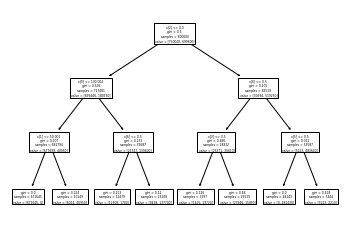

In [32]:
plot_tree(modelo)

Profundidad del árbol: 3
Número de nodos terminales: 8


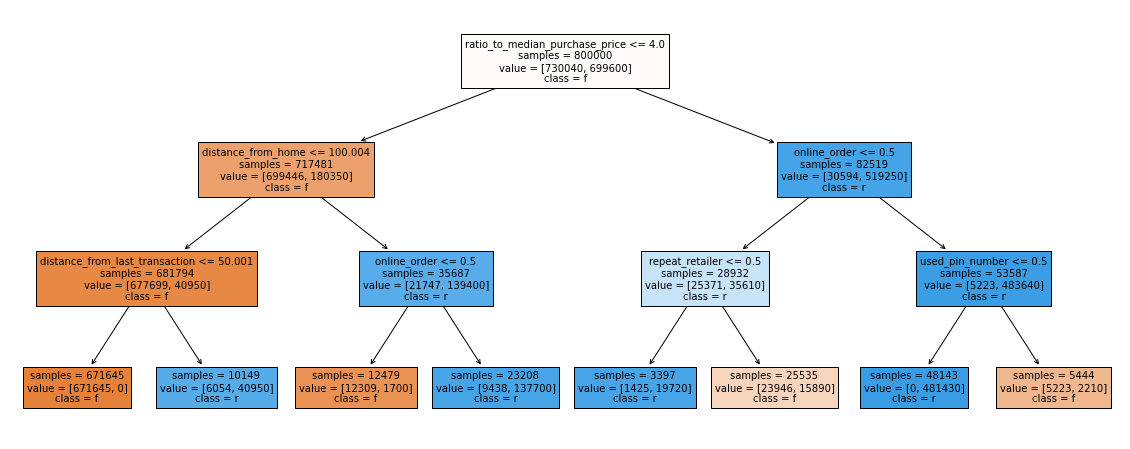

In [33]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 8))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = df.drop('fraud', axis=1).columns,
            class_names   = 'fraud',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 3,
            ax            = ax
       )

In [34]:
from sklearn.tree import export_graphviz

In [35]:
dot_data = export_graphviz(modelo,
                         class_names = ['No-Fraude', 'Fraude'] ,
                filled = True, rounded = True,
                special_characters = True)
graph = graph_from_dot_data(dot_data)
graph.write_png('arbol_profundidad_3.png')

True

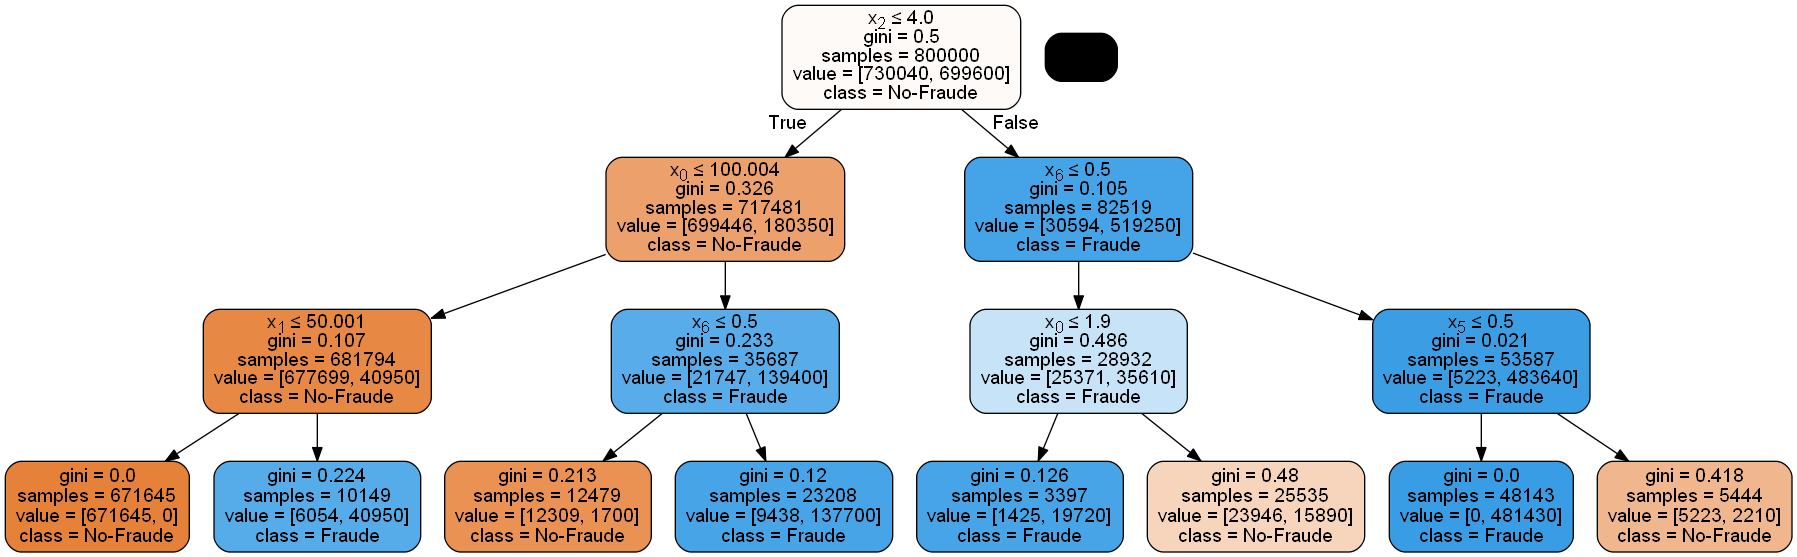

En la tabla siguiente se muestran los predictores mas importantes del modelo, tal como se habia podido observar cuando se grafico la matriz de correlación.

In [36]:
importances = pd.DataFrame({'Predictor':X_train.columns,'importancia':np.round(modelo.feature_importances_,3)})
importances = importances.sort_values('importancia',ascending=False)
importances

,Predictor,importancia
2,ratio_to_median_purchase_price,0.562
0,distance_from_home,0.261
1,distance_from_last_transaction,0.101
6,online_order,0.053
3,repeat_retailer,0.012
5,used_pin_number,0.011
4,used_chip,0.000
7,distancia,0.000


Ahora queda ver la matriz de confusión para una evaluación mas rigurosa de los resultados del modelo. 

La matriz de confusión es una herramienta utilizada en el campo de la clasificación para evaluar el rendimiento de un modelo. Proporciona una representación visual de las predicciones realizadas por el modelo en comparación con las clases reales.

Es una matriz cuadrada que muestra el recuento de las clasificaciones correctas e incorrectas realizadas por un modelo en cada clase. En su forma más simple, una matriz de confusión para un problema de clasificación binaria tiene cuatro celdas:

- Verdaderos positivos (TP): Representa los casos en los que el modelo predijo correctamente una muestra como positiva en una clase determinada.

- Falsos positivos (FP): Representa los casos en los que el modelo predijo incorrectamente una muestra como positiva en una clase determinada.

- Verdaderos negativos (TN): Representa los casos en los que el modelo predijo correctamente una muestra como negativa en una clase determinada.

- Falsos negativos (FN): Representa los casos en los que el modelo predijo incorrectamente una muestra como negativa en una clase determinada


Proporciona una visión general del rendimiento del modelo y es especialmente útil cuando las clases están desequilibradas.

Matriz de Confusión:


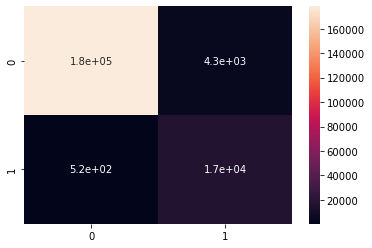

In [37]:
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')

## np.set_printoptions(suppress=True) # evita la notacion cientifica

sns.heatmap(matriz, annot=True)
plt.show()

Los resultados indican que hay muchos valores mal clasificados (errores tipo 1 y tipo 2), lo que nos lleva a una modificacion de los hiperparametros del modelo para ver si asi se obtienen mejores resultados.

El reporte siguiente proporciona algunas metricas de evaluacion en base a los resultados de la matriz de confusión

- Precisión (precision): Mide la proporción de muestras positivas predichas correctamente sobre todas las muestras predichas como positivas.

- Recall (sensibilidad o tasa de verdaderos positivos): Mide la proporción de muestras positivas predichas correctamente sobre todas las muestras realmente positivas.

- F1-Score: Es la media armónica de la precisión y el recall, proporcionando una medida equilibrada que tiene en cuenta tanto los falsos positivos como los falsos negativos.

- Soporte (support): El número de muestras en cada clase.

- Promedio ponderado (weighted average) y promedio macro (macro average) de las métricas anteriores. El promedio ponderado da más peso a las clases con más muestras, mientras que el promedio macro calcula las métricas por clase y luego toma el promedio sin tener en cuenta el desequilibrio de clases.

In [38]:
# Paso 5: Evaluar el rendimiento utilizando métricas de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    182557
         1.0       0.80      0.97      0.88     17443

    accuracy                           0.98    200000
   macro avg       0.90      0.97      0.93    200000
weighted avg       0.98      0.98      0.98    200000



A pesar de los buenos resultados de las metricas recien evaluadas, la matriz de confusion muestra que hay muchos valores mal clasificados, lo cual requiere un ajuste de los hiperparametros del modelo para comparar los resultados.

In [39]:
arbol = DecisionTreeClassifier()
arbol.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

on el fin de optimizar los hiperparametros del modelo se realiza el siguiente metodo de Búsqueda en cuadrícula (Grid Search): La búsqueda en cuadrícula es una técnica que permite explorar exhaustivamente diferentes combinaciones de hiperparámetros para encontrar la configuración óptima del modelo. En el ejemplo de código que sigue, el diccionario "parametros" contiene los hiperparámetros que se van a ajustar y sus valores posibles. GridSearchCV realiza una validación cruzada en todas las combinaciones posibles de hiperparámetros y evalúa el rendimiento del modelo utilizando la métrica especificada

La métrica average_precision_score se utiliza comúnmente para evaluar modelos de clasificación cuando el objetivo principal es la recuperación de clases positivas. Es especialmente útil cuando tienes un conjunto de datos desequilibrado, es decir, cuando una clase es mucho más frecuente que la otra.

La precisión promedio (average precision) mide la calidad de la clasificación de una clase positiva en función de la tasa de recuperación o recall (recall). La tasa de recuperación se refiere a la proporción de instancias positivas que se identifican correctamente.

La métrica average_precision_score calcula la precisión promedio para diferentes valores de umbral de decisión y luego promedia estos valores. El umbral de decisión determina el nivel de confianza necesario para clasificar una instancia como positiva.

El cálculo de la precisión promedio implica calcular la precisión en cada punto de recuperación (cuando se recupera una instancia positiva adicional) y luego tomar el promedio de estos valores. Esto da una idea de qué tan bien se clasifican las instancias positivas en general a medida que aumenta la tasa de recuperación.

In [41]:
from sklearn.model_selection import GridSearchCV

weights1 = {0: 1, 1: 10}
weights2 = {0: 1, 1: 100}

parametros = {'criterion': ('gini', 'entropy'),
              'max_depth': (3, 5, 7),
              'class_weight':(weights1, weights2, 'balanced')}

scorer = make_scorer(average_precision_score, needs_proba=True)

rejilla = GridSearchCV(arbol, parametros, scoring = scorer)
rejilla.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ({0: 1, 1: 10}, {0: 1, 1: 100},
                                          'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (3, 5, 7)},
             scoring=make_scorer(average_precision_score, needs_proba=True))

In [42]:
print(rejilla.cv_results_["rank_test_score"])
print(rejilla.cv_results_["mean_test_score"])
print(rejilla.best_score_)

[16 10  2 13  8  1 18 12  5 15 11  6 16  9  2 13  7  4]
[0.94711427 0.99938697 0.99986706 0.94742471 0.99938718 0.9998944
 0.94283546 0.99713592 0.99985512 0.94712778 0.99938564 0.99985153
 0.94711427 0.99938698 0.99986706 0.94742471 0.99938718 0.99986582]
0.999894399963828


In [43]:
# Obtener los mejores hiperparámetros encontrados
best_params = rejilla.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'class_weight': {0: 1, 1: 10}, 'criterion': 'entropy', 'max_depth': 7}


In [44]:
# Entrena el modelo con los mejores hiperparámetros encontrados
best_clf = DecisionTreeClassifier(**best_params)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                       max_depth=7)

In [45]:
# Realiza predicciones en el conjunto de prueba
y_pred = best_clf.predict(X_test)

[Text(0.4460227272727273, 0.9375, 'x[2] <= 4.0\nentropy = 1.0\nsamples = 800000\nvalue = [730040, 699600]'),
 Text(0.1534090909090909, 0.8125, 'x[0] <= 100.004\nentropy = 0.732\nsamples = 717481\nvalue = [699446, 180350]'),
 Text(0.045454545454545456, 0.6875, 'x[1] <= 50.001\nentropy = 0.315\nsamples = 681794\nvalue = [677699, 40950]'),
 Text(0.022727272727272728, 0.5625, 'entropy = 0.0\nsamples = 671645\nvalue = [671645, 0]'),
 Text(0.06818181818181818, 0.5625, 'x[6] <= 0.5\nentropy = 0.554\nsamples = 10149\nvalue = [6054, 40950]'),
 Text(0.045454545454545456, 0.4375, 'entropy = 0.0\nsamples = 3490\nvalue = [3490, 0]'),
 Text(0.09090909090909091, 0.4375, 'x[4] <= 0.5\nentropy = 0.323\nsamples = 6659\nvalue = [2564, 40950]'),
 Text(0.045454545454545456, 0.3125, 'x[5] <= 0.5\nentropy = 0.09\nsamples = 4273\nvalue = [440, 38330]'),
 Text(0.022727272727272728, 0.1875, 'entropy = 0.0\nsamples = 3833\nvalue = [0, 38330]'),
 Text(0.06818181818181818, 0.1875, 'entropy = 0.0\nsamples = 440\nva

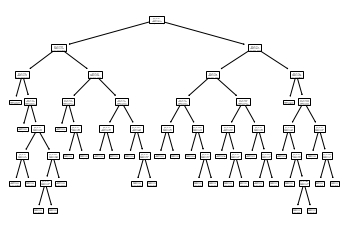

In [46]:
plot_tree(best_clf)

Profundidad del árbol: 7
Número de nodos terminales: 34


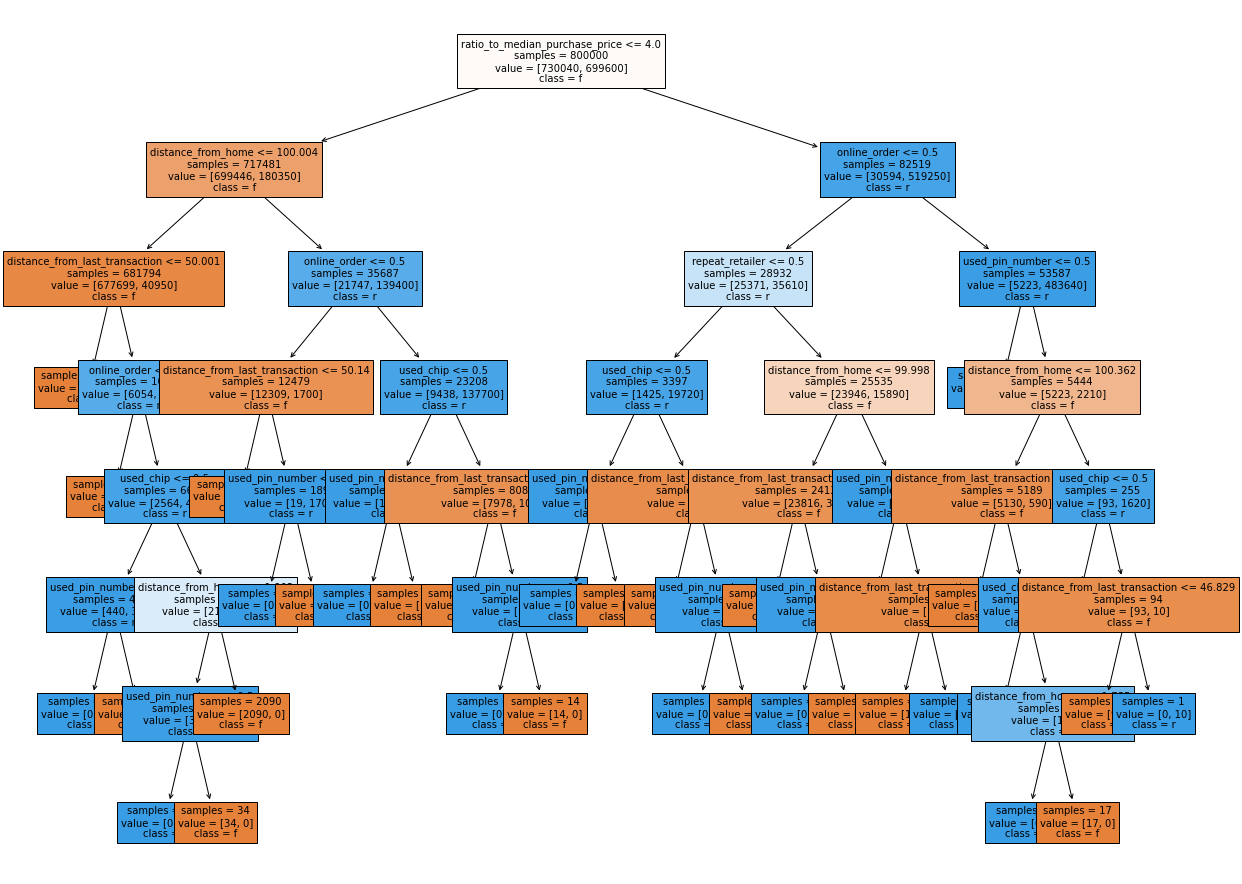

In [47]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 16))

print(f"Profundidad del árbol: {best_clf.get_depth()}")
print(f"Número de nodos terminales: {best_clf.get_n_leaves()}")

plot = plot_tree(
            decision_tree = best_clf,
            feature_names = df.drop('fraud', axis=1).columns,
            class_names   = 'fraud',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 3,
            ax            = ax
       )

In [50]:
dot_data2 = export_graphviz(best_clf,
                         class_names = ['No-Fraude', 'Fraude'] ,
                filled = True, rounded = True,
                special_characters = True)
graph = graph_from_dot_data(dot_data2)
graph.write_png('arbol_final.png')

True

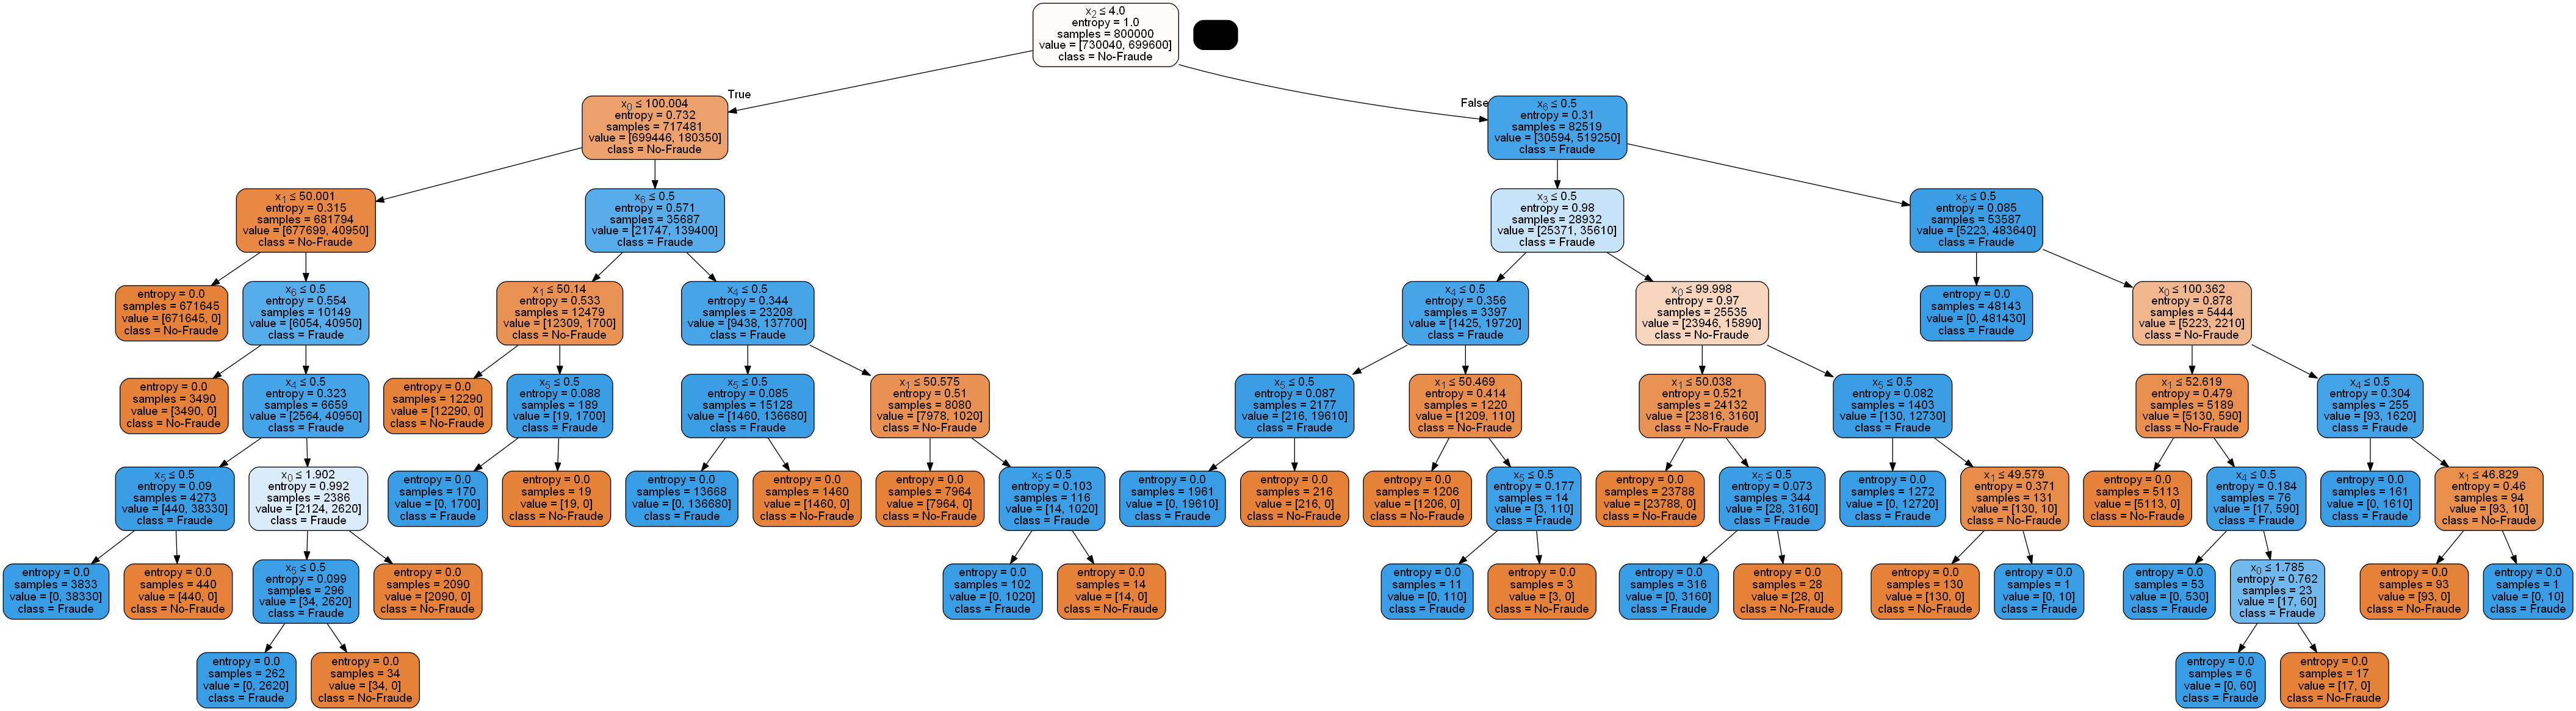

In [51]:
importances2 = pd.DataFrame({'Predictor':X_train.columns,'importancia':np.round(best_clf.feature_importances_,3)})
importances2 = importances.sort_values('importancia',ascending=False)
importances2

,Predictor,importancia
2,ratio_to_median_purchase_price,0.562
0,distance_from_home,0.261
1,distance_from_last_transaction,0.101
6,online_order,0.053
3,repeat_retailer,0.012
5,used_pin_number,0.011
4,used_chip,0.000
7,distancia,0.000


In [52]:
# Calcula la precisión y el recall del modelo en el conjunto de prueba
precision = average_precision_score(y_test, y_pred)

print("Precisión del modelo en el conjunto de prueba:", precision)

Precisión del modelo en el conjunto de prueba: 0.9998380145234692


Matriz de Confusión:


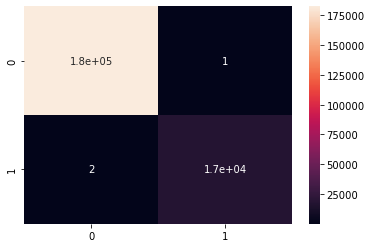

In [53]:
matriz_final = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')


sns.heatmap(matriz_final, annot=True)
plt.show()

In [54]:
# Evaluar el rendimiento utilizando métricas de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



Llegados a este punto, se puede observar que los cambios en los hiperparametros han sido beneficiosos para la mejora en la capacidad de clasificación del modelo, reduciendo sustancialmente los errores tipo I y tipo II. 

Queda ahora evaluar el impacto economico que tiene la aplicación de este modelo, lo que se traduce en evaluar los costos monetarios producidos no prevenir los casos de fraude versus el ahorro generado para la empresa de detectar dichos casos.

Para lo que sigue se creara una variable que representa valores ficticios de transacciones con tarjeta de credito, suponiendo que estos valores pueden tener distribucion normal y que estan expresados en dolares norteamericanos. Es importante aclarar que estos datos no son provistos en el DataSet original y que solo se crean con la finalidad de ver el impacto del modelo. Ademas, se considera que el conjunto de datos corresponden a transacciones realizadas en el periodo de un año, el cual no esta especificado.

In [55]:
# Generar 1 millón de valores ficticios para la columna de transacciones
num_transactions = 1000000

# Generar montos ficticios utilizando una distribución normal
mean_amount = 100.0  # Media de los montos de transacción
std_amount = 20.0  # Desviación estándar de los montos de transacción

# Generar los montos ficticios
amounts = np.random.normal(mean_amount, std_amount, num_transactions)

# Agregar los montos ficticios al DataFrame
df['monto_transaccion'] = amounts

In [57]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,distancia,monto_transaccion
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0,3,107.731792
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0,2,105.104073
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0,1,85.224292
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0,0,78.985504
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0,3,98.563689


Con estos nuevos valores ahora se puede calcular el costo promedio de fraude, lo cual sera util a la hora de evaluar el impacto del modelo.

In [58]:
# Calcular el costo promedio de las transacciones fraudulentas
costo_fraude = df.loc[df["fraud"] == 1.0, "monto_transaccion"].mean()

print("Costo promedio de transacciones fraudulentas: $", costo_fraude)

Costo promedio de transacciones fraudulentas: $ 100.01206712156318


In [59]:
## ahora tambien suponemos los siguientes valores

costo_investigacion = 50  # Costo promedio de investigar y resolver cada caso de fraude
costo_falso_positivo = 15  # Costo de las transacciones legítimas clasificadas erróneamente como fraudulentas

In [60]:
# Extraer los valores de la matriz de confusión
verdaderos_positivos = matriz_final[1, 1]
falsos_positivos = matriz_final[0, 1]
fraudes_no_detectados = matriz_final[1, 0]

In [61]:
# Calcular el ahorro por detección de fraude

ahorro_fraude = fraudes_no_detectados * costo_fraude
ahorro_investigacion = verdaderos_positivos * costo_investigacion
costo_falsos_positivos = falsos_positivos * costo_falso_positivo

ahorro_total = ahorro_fraude + ahorro_investigacion - costo_falsos_positivos

print("Ahorro por detección de fraude: $", ahorro_total)

Ahorro por detección de fraude: $ 872235.0241342431


Ahora se procedera a calcular el costo que implicaria para la empresa el hecho de no aplicar un modelo de deteccion de fraude

In [62]:
# Calcular la tasa de fraude
total_transacciones = len(df)
transacciones_fraude = len(df[df["fraud"] == 1.0])

tasa_fraude = transacciones_fraude / total_transacciones

print("Tasa de Fraude:", tasa_fraude)

Tasa de Fraude: 0.087403


In [63]:
# Calcular el número de transacciones fraudulentas
numero_fraudes = total_transacciones * tasa_fraude

# Calcular el costo total de fraude no detectado
costo_fraude_no_detectado = numero_fraudes * costo_fraude

print("Costo por no detectar fraude: $", costo_fraude_no_detectado)

Costo por no detectar fraude: $ 8741354.702625986


En base a estos ficticios sobre transacciones, se pudo ver que de no aplicar el modelo las perdidas economicas son muy grandes (suponiendo que la empresa tuviera responsabilizarse con el cliente por el valor promedio de las transacciones fraudulentas) y eso sin tener en cuenta el impacto de la perdida potencial de clientes molestos por esta situación.

Entonces, con la aplicacion del Arbol de Decision se consigue evitar esta enorme perdida, sumado al ahorro de estar haciendo frente a los costos que implica la resolucion de cada caso de fraude detectado. 

Seria optimo tener valores reales referidos a transacciones con tarjeta de credito para tener una nocion mas clara sobre los resultados del modelo, aunque con los valores supuestos se cumple con el objetivo de mostrar que es realmente util la aplicacion de este modelo

## Conclusiones

En el presente trabajo se realizo un analisis exploratorio de datos para indagar sobre la base de datos referida a fraudes con tarjeta de credito, donde se pudo observar variables relevantes que despues resultaron ser importantes predictoras en la aplicacion de nuestro modelo de Machine Learning. Ademas, se trataron aplicaciones muy importantes como la busqueda en rejilla para una mejora en los hiperparametros del modelo de Arbol de Decision asi como el uso de una herramienta muy util para evaluar el impacto del modelo como lo es la Matriz de Confusion. Finalmente se hicieron algunas souposiciones referidas a valores ficticios sobre montos de transacciones con tarjeta de credito con el fin de evaluar el impacto economico del modelo y asi concluir que es de suma utilidad a la hora de prevenir grandes perdidas monetarias por detectar transacciones fraudulentas.